## **Is it a Bird?**

In [3]:
from fastbook import *
import torch

c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### **Step 1:** Download images of birds and non-birds

In [4]:
from fastcore.all import *

from duckduckgo_search import DDGS

# A function to get images from DuckDuckGo
def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')       # L is a list type, .itemgot('image') extracts the image

In [5]:
# Downloading the URL for an image of a bird
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for bird photos


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

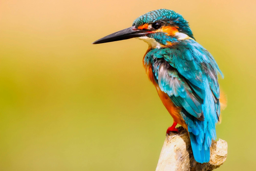

In [6]:
# Viewing the image of a bird
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

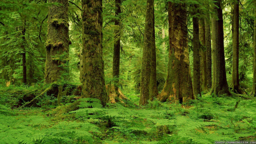

In [7]:
# Similarly, viewing the image of a forest
download_url(search_images_ddg('forest_photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

Computer vision models usually don't require high quality images.

Surprisingly a lot of the computer's processing power goes in opening the image, and less so in running the AI model.

This is why it makes sense to resize the image and make them smaller, so GPUs/CPU spends less time in opening the images, takes up less storage in saving the images, and making the model faster to execute.

As we can see that we are getting relevant images, we can try grabbing more images of each type.

We will be grabbing images in a variety of lighting conditions like shade, sun, etc.

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for forest photo
Searching for forest sun photo
Searching for forest shade photo
Searching for bird photo
Searching for bird sun photo
Searching for bird shade photo


### **Step 2:** Training a model

Having image files which are corrupted/aren't downloaded properly can cause errors later on, so it's important that we remove them

In [9]:
 # Removing failed downloads
 failed = verify_images(get_image_files(path))          # Returns a list of all the image files
 failed.map(Path.unlink)                # To delete the failed download files
 len(failed)

4

To train a model, we need `DataLoaders`, which is an object containing a training and testing set of data used to create a model. We can easily create a DataLoader using `DataBlock`.

All the things that change from project to project can be split down into 5 things, which we define in the `DataBlock`. Based on this information, the DataBlock decides what kind of model to create.

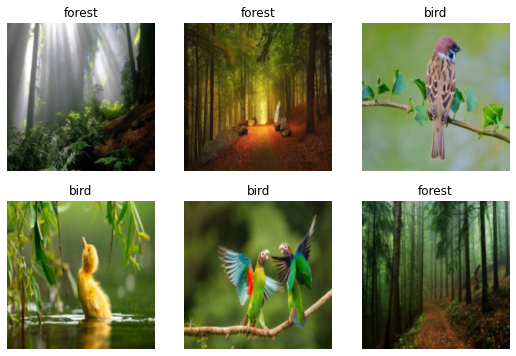

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                 # Input -> Image, Output -> Category (Label)
    get_items=get_image_files,                          # Will use get_image_files function to get images to train from
    splitter=RandomSplitter(valid_pct=0.2, seed=42),    # Defining the train/test split, here we randomly put aside 20% of the data as test data
    get_y=parent_label,                                 # Where will we get the correct labels from, in this case from the parent folder of the path as e.g. bird photos are stored in a folder called bird
    item_tfms=[Resize(192, method='squish')]            # All inputs should be of the same size, so we are making all images 192x192 px by 'squishing' the images, other methods are available
).dataloaders(path)                         # PyTorch uses dataloaders to load data using CPU/GPU in batches

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)       # Passing in the data, model to use and the metrics to consider
learn.fine_tune(3)                  # Adjusts the model to fit our data, 3 is the number of epochs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Vansh/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.411957,0.063800,0.020833,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.011069,0.004613,0.000000,01:15
1,0.007181,0.000731,0.000000,01:19
2,0.004164,0.000226,0.000000,01:16


From the results, we can notice that the error rate is same for multiple epochs while finetuning. So we may have gotten similar results if we hadn't finetuned the model OR finetuned the model for fewer epochs.

While finetuning may have not had a huge impact here, finetuning is VERY important and does improve performance by a lot usually, especially for more complex tasks.

### **Step 3:** Using the model to make predictions

In [17]:
# Making predictions
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))      # Stores the result whether it is a bird or not, a placeholder variable (not relevant to us), and the probability of it being a bird
print(f"This is a {is_bird}")
print(f"Probability that it is a bird: {probs[0]:.2f}")

This is a bird
Probability that it is a bird: 1.00


Deep learning is not only useful for computer vision tasks, but also for text, sound, etc!
Similarly to how we trained a model to classify whether an image was of a bird or not, we can train a model to perform a range of tasks, like calculating the average life expectancy of a person given a few parameters, predicting movie box office numbers based on critic reviews, etc.